In [1]:
import os
import cv2     # for capturing videos
import math 
import geocoder
import requests
%matplotlib inline
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt 
from skimage.transform import resize   # for resizing images
from keras.layers import Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
count = 0
videoFile = "Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


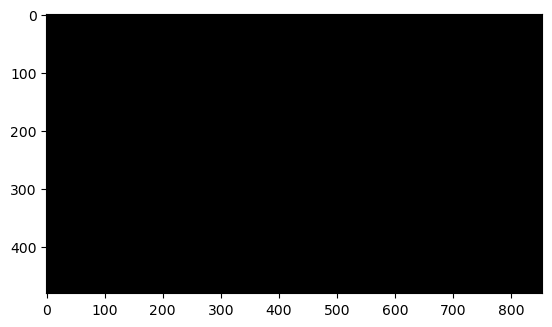

In [3]:
img = plt.imread('0.jpg')   # reading image using its name
plt.imshow(img)

In [4]:
data = pd.read_csv('mapping.csv')     # reading the csv file
data.head()

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1


In [5]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [6]:
y = data.Class
dummy_y = to_categorical(y)

In [7]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [8]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [10]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [11]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [12]:
X_train_features = base_model.predict(X_train)
X_valid_features = base_model.predict(X_valid)
X_train.shape, X_valid.shape

5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


((155, 224, 224, 3), (67, 224, 224, 3))

In [13]:
X_train_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_valid_flat = X_valid_features.reshape(X_valid_features.shape[0], -1)

In [14]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [15]:
model = Sequential()
model.add(Flatten())  # Flatten the output of VGG16
model.add(Dense(units=256, activation='relu'))  # Reduce the number of units
model.add(Dropout(0.5))  # Add Dropout for regularization
model.add(Dense(units=128, activation='relu'))  # Further reduce complexity
model.add(Dropout(0.5))  # Add Dropout for regularization
model.add(Dense(units=2, activation='softmax'))  # Output layer

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 178ms/step - accuracy: 0.9645 - loss: 1.5866 - val_accuracy: 0.7313 - val_loss: 64.5448
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9619 - loss: 1.0370 - val_accuracy: 0.7761 - val_loss: 71.0172
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9689 - loss: 0.9665 - val_accuracy: 0.7463 - val_loss: 73.8247
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9662 - loss: 5.6449 - val_accuracy: 0.7164 - val_loss: 71.1216
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9689 - loss: 1.0336 - val_accuracy: 0.7612 - val_loss: 68.2361
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9637 - loss: 3.1685 - val_accuracy: 0.7910 - val_loss: 66.5818
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9848 - loss: 0.3809 - val_accuracy: 0.8209 - val_loss: 65.7165
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9702 - loss: 0.4439 - val_accuracy: 0.8060 - val_loss:

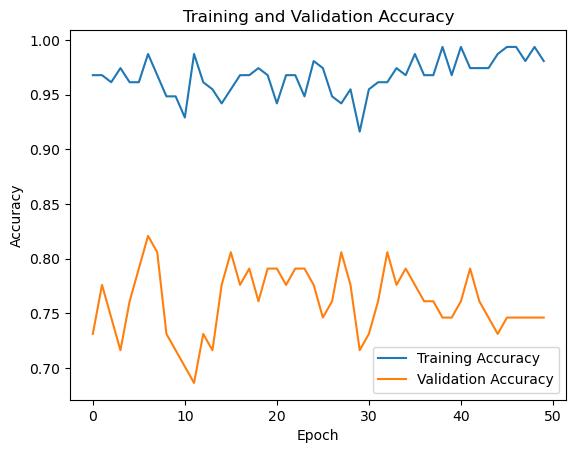

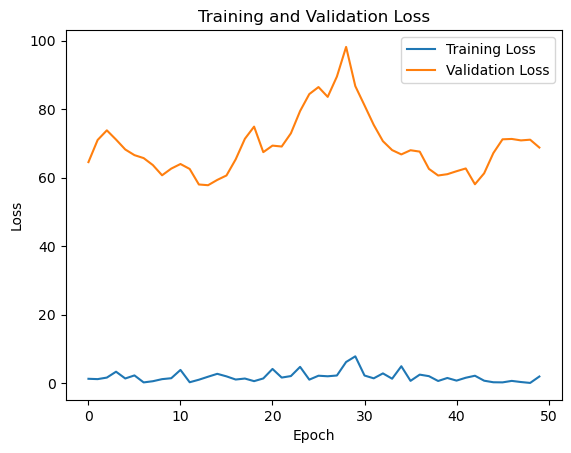

    accuracy      loss  val_accuracy   val_loss
1   0.967742  1.257673      0.731343  64.544785
2   0.967742  1.159755      0.776119  71.017174
3   0.961290  1.608018      0.746269  73.824669
4   0.974194  3.326194      0.716418  71.121590
5   0.961290  1.348593      0.761194  68.236122
6   0.961290  2.241840      0.791045  66.581848
7   0.987097  0.198525      0.820895  65.716469
8   0.967742  0.548811      0.805970  63.681660
9   0.948387  1.152742      0.731343  60.695499
10  0.948387  1.425187      0.716418  62.650940
11  0.929032  3.846005      0.701493  63.991230
12  0.987097  0.246445      0.686567  62.550945
13  0.961290  0.983340      0.731343  58.010448
14  0.954839  1.863795      0.716418  57.798328
15  0.941935  2.707757      0.776119  59.346828
16  0.954839  1.963963      0.805970  60.643291
17  0.967742  1.039907      0.776119  65.351631
18  0.967742  1.329900      0.791045  71.355934
19  0.974194  0.567103      0.761194  74.910912
20  0.967742  1.358619      0.791045  67

In [21]:
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train_flat, y_train, epochs=100, batch_size=32, validation_data=(X_valid_flat, y_valid))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Create a table for accuracy and loss
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df.index += 1  # Adjust index to start from 1 instead of 0
print(history_df)


In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
count = 0
videoFile = "Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


In [24]:
test = pd.read_csv('test.csv')

In [25]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [26]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [27]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


(9, 7, 7, 512)

In [28]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max(axis=1, keepdims=True) 

In [29]:
predictions = model.predict(test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


In [30]:
print(predictions)

[[0.21335949 0.7866405 ]
 [0.28319147 0.7168085 ]
 [0.36076167 0.6392383 ]
 [0.35281476 0.64718527]
 [0.37186924 0.62813073]
 [0.46137124 0.5386288 ]
 [0.57764155 0.4223584 ]
 [0.59533715 0.40466282]
 [0.68117094 0.3188291 ]]


In [31]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")
    

No Accident
No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident


In [32]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid = 'AC604c141abcb723bf42922574e50ffd69'
auth_token = '5d6fd569ce5407780e379f6eacb630aa'
client = Client(account_sid, auth_token)

In [36]:
cap = cv2.VideoCapture('Accident-1.mp4')
i=0
flag=0
while(True):
    ret, frame = cap.read()
    if ret == True:
        if predictions[int(i/15) % 9][0] < predictions[int(i/15) % 9][1]:
            predict = "No Accident"
        else:
            predict = "Accident"
            flag = 1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                predict,
                (50, 50),
                font, 1,
                (0, 255, 255),
                3,
                cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag==1:
    client.messages.create(
                 body="Accident detected in "+locname.address,
                      from_= +12058093734,
                 to=  +919118604416 )

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()
